In [1]:
import sys
import json
import numpy as np
import matplotlib.pyplot as plt
import line_profiler

from usgs.helpers import *
from usgs.filters import *
from usgs.imputation.imputation import *
from pymongo import MongoClient
from numpy.lib.stride_tricks import as_strided

client = MongoClient("localhost", 27017)
db = client['usgs']

%matplotlib inline
plt.rcParams['image.cmap'] = 'viridis'
plt.rcParams['axes.grid'] = True
plt.rcParams['axes.grid.which'] = 'both'
plt.rcParams['figure.figsize'] = [16.0, 8.0]

In [2]:
# mis-alignment
2198000, 2422500, 2318700, 15743850

(2198000, 2422500, 2318700, 15743850)

In [3]:
sites     = db['sites']
measured  = db['measured']
corrected = db['corrected']

cursor = sites.find()
sid = [c['site_no'] for c in cursor]

# Error checking

In [5]:
def ts_process(q, db, site_list):
    for site_id in site_list:
        try:
            t_raw, z_raw, t_true, z_true = get_data(db, site_id)
        except:
            continue

        z_raw  = feet_to_meters(z_raw)
        z_true = feet_to_meters(z_true)
        dt, y_raw, y_true = align_measurements(t_raw, z_raw, t_true, z_true)

        if dt < 300:
            continue 

        idx = y_true > 0
        mask = extreme_values(z_raw, continuity = 0.13, high = True, low = True)
        z_new = z_raw.copy()
        z_new[mask] = -1

        _, y_new, _ = align_measurements(t_raw, z_new, t_true, z_true)

        y_raw  = linear_interpolator(y_raw,  max_gap = y_raw.size)
        y_new  = linear_interpolator(y_new,  max_gap = y_new.size)
        y_true = linear_interpolator(y_true, max_gap = y_true.size)

        is_spike = detect_spikes(y_new, dt, min_amp = 0.5, thr = 0.1)
        y_new = fix_spikes(y_new, is_spike)

        mae_raw = mae(y_raw[idx], y_true[idx])
        mae_new = mae(y_new[idx], y_true[idx])
        mxae_raw = mxae(y_raw[idx], y_true[idx])
        mxae_new = mxae(y_new[idx], y_true[idx])

        print("%i \t%.6f   \t%.6f   \t%.6f   \t%.6f" % \
              (site_id, mae_raw, mae_new, mxae_raw, mxae_new))
        sys.stdout.flush()
        q.put((site_id, [mae_raw, mae_new, mxae_raw, mxae_new]))
    return 0

In [ ]:
from multiprocessing import Process, Queue, Manager

n_cores = 8
n = len(sid)
k = n // n_cores

manager = Manager()
q = manager.Queue()
jobs = list()
for i in range(n_cores):
    sid_chunk = sid[i*k:min((i+1)*k, n)]
    p = Process(target=ts_process, args=(q, db, sid_chunk))
    jobs.append(p)
    p.start()
    
for job in jobs:
    job.join()
    
m = q.qsize()
site_id = np.zeros(m)
mae_raw = np.zeros(m)
mae_new = np.zeros(m)
mxae_raw = np.zeros(m)
mxae_new = np.zeros(m)

for i in range(m):
    k, v = q.get()
    site_id[i] = k
    mae_raw[i] = v[0]
    mae_new[i] = v[1]
    mxae_raw[i] = v[2]
    mxae_new[i] = v[3]

print('...done.')
sys.stdout.flush()

In [ ]:
idx = mae_raw > mae_new + 0.000001
print('MAE reduced: %.1f%%' % (np.sum(idx) / idx.size * 100))

idx = mxae_raw > mxae_new + 0.0001
print('MxAE reduced: %.1f%%' % (np.sum(idx) / idx.size * 100))

idx = mxae_raw > mxae_new + 1
print('MxAE reduced (1m): %.1f%%' % (np.sum(idx) / idx.size * 100))

idx = mae_raw > mae_new + 0.1
print('MAE reduced (.1m): %.1f%%' % (np.sum(idx) / idx.size * 100))

idx = (mxae_raw > 0.025) & (mxae_new < 0.025)
print('MxAE reduced lower than 1ft: %.1f%%' % (np.sum(idx) / idx.size * 100))

idx = mxae_raw < 0.01
print('MxAE lower than 1ft: %.1f%%' % (np.sum(idx) / idx.size * 100))

print('Avg error change: %.6f' % np.mean(mae_new - mae_raw))

In [ ]:
site_id_gold = [5124480, 8078000, 7151500, 4185000, 2198000, 
                8109700, 2422500, 3574500, 2318700, 2361000, 
                3543500, 9361500, 7268000, 6800000, 8041700,
                2326000, 2329500, 11152000, ]
8095300, 2233500, 12321500, 1601500

In [ ]:
erosions and dilations cut off high peaks and low valleys and can possibly help 
to remove pressure leaks and oscilations. After dilation/erosion remember locations 
of platos into "mask", then smooth the signal, then remove those points of platos and
interpolate with bezier splines. 

In [6]:
def plot_ts(y, z, grid = (4,1), h = 3):
    n = grid[0] * grid[1]
    k = y.size // n
    plt.figure(figsize = (16, grid[0]*h))
    for i in range(n):
        plt.subplot(grid[0], grid[1], i+1)
        plt.plot(y.data[i*k : (i+1)*k], 'b.-')
        plt.plot(z.data[i*k : (i+1)*k], 'r-')
        plt.xlim(0, k)


def pressure_leak_kernel(k):
    m = k // 3
    kernel = np.ones(k)
    kernel[m:2*m] = np.linspace(1,0,m)**2
    return kernel #/ kernel.sum()

In [37]:
def adaptive_filter_1d(y, max_kernel_size, filter_func):
    n = y.size
    k_max = max_kernel_size
    res = y.copy()
    b = y.min()
    a = np.log(k_max) / (y.max() - b)
    for i in range(k_max, n-k_max-1):
        #sample = y[i-k_max:i+k_max+1]
        #rng = sample.max() - sample.min()
        k = np.int32(k_max * np.exp(-a*(y[i] - b))) #
        res[i] = filter_func(y[i-k:i+k+1])
    return res

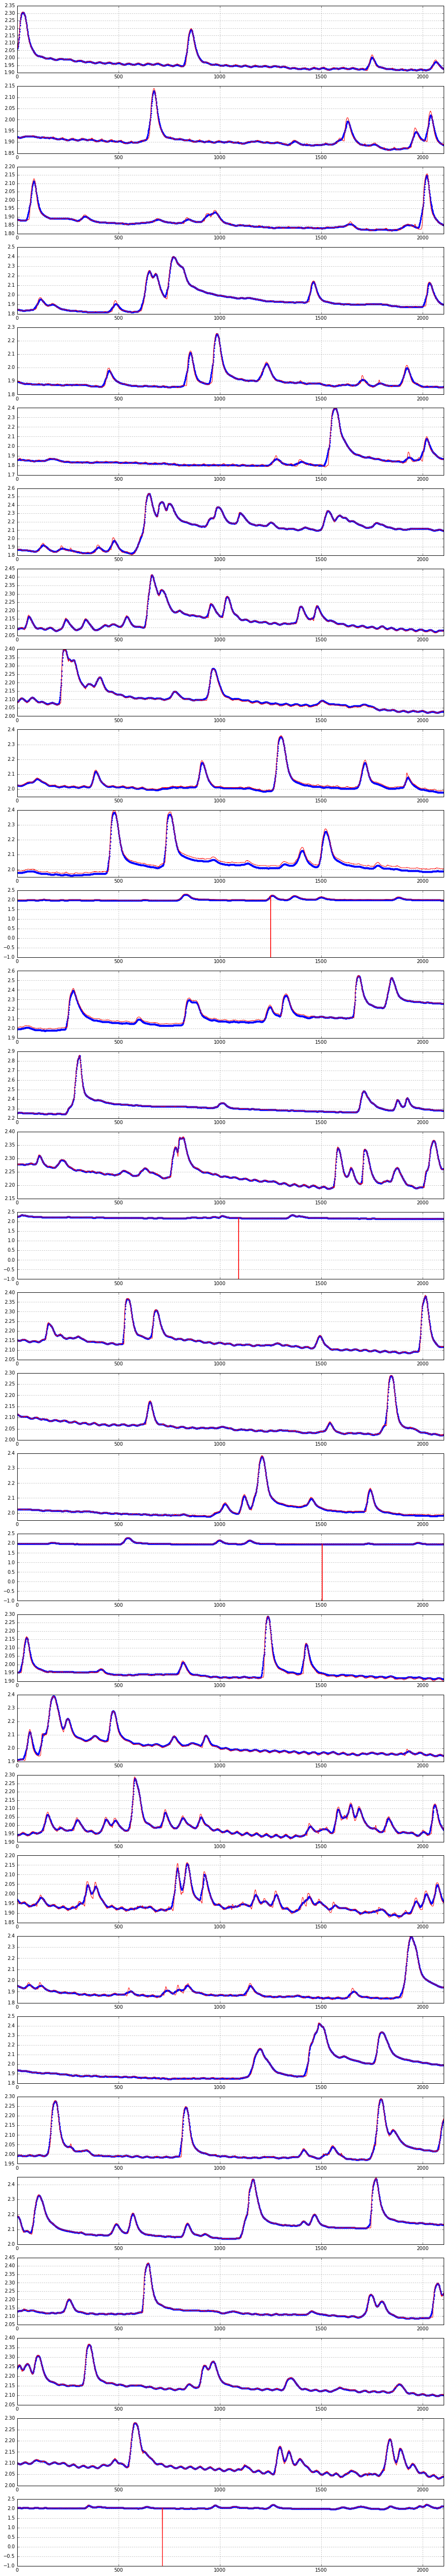

In [46]:
site_id = sid[11]

z, w = get_data(db, site_id)
z.x = ft_to_m(z.x)
w.x = ft_to_m(w.x)

dz = ma.hstack([1, z.x[1:] - z.x[:-1]])

сonst_mask = (dz.data == 0) & (z.x > np.percentile(z.x, 60))
extreme_mask = extreme_values(z.x, continuity = 0.13)
z.x[сonst_mask | extreme_mask] = -1

dt, y, u = align_measurements(z, w)
y = linear_interpolator(y, max_gap = 14*86400/dt)
y = median_filter_1d(y, 5)
y = adaptive_filter_1d(y, 12*3600 // dt, np.mean)
#y.fill_value = -1

#kernel = pressure_leak_kernel(300)
#u = roll_std_1d(np.hstack([1, y[1:] - y[:-1]]), 499)
#e = roll_dist_1d(y, kernel)

#spikes_mask = detect_spikes(y, dt, 0.05, 0.25)
#y.data[spikes_mask] = -1
#y.mask[spikes_mask] = True
#y = linear_interpolator(y, max_gap = 14*86400//dt)

plot_ts(y, u, grid = (32,1))

In [96]:
def pressure_leak_kernel(k):
    m = k // 3
    kernel = np.ones(k)
    kernel[m:2*m] = np.linspace(1,0,m)
    return kernel / kernel.sum()

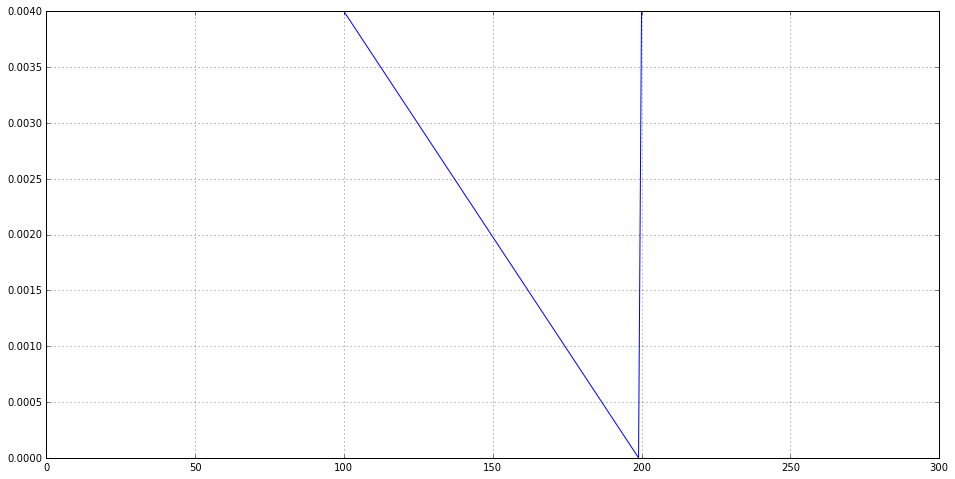

In [107]:
#kernel = y[31*4200-380:31*4200-200]
#kernel = kernel / kernel.sum()
#kernel = pressure_leak_kernel(300)
#kernel /= kernel.sum()
plt.plot(kernel)